In [1]:
import numpy as np 
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sn

# Загрузка и предобработка данных

In [2]:
def to_categorical(label_array, count_number=10):
    """Пердставить лейбал в виде массива со значением"""
    label_array = np.array(label_array) 
    n = label_array.shape[0]
    categorical = np.zeros((n, count_number))
    categorical[np.arange(n), label_array] = 1
    return categorical


In [3]:
def load_data():
    """Загрузка датасета"""
    (train_X, train_Y), (test_X, test_Y) = mnist.load_data()

    print(train_X.shape)
    # преобразование в 1 канал 
    train_X = train_X.reshape((train_X.shape[0], 28, 28))/255.
    test_X = test_X.reshape((test_X.shape[0], 28, 28))/255.
    
    # перевод в one hot encoder 
    train_Y = to_categorical(train_Y)
    test_Y = to_categorical(test_Y)

    return (train_X.round(), train_Y), (test_X.round(), test_Y)

In [4]:
(train_X, train_Y), (test_X, test_Y) = load_data()

(60000, 28, 28)


In [5]:
train_X[1].max()

1.0

In [6]:
train_Y[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

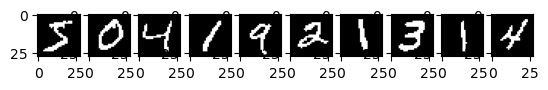

In [7]:
f  = plt.figure()
for i, image  in enumerate(train_X[:10]):
    f.add_subplot(1,10, i+1)
    plt.imshow(image, cmap="gray")
plt.show()

In [366]:
class Softmax:
    def forward(self, x):
        x = x - np.max(x)
        self.p = np.exp(x) / np.sum(np.exp(x))
        return self.p

    def backward(self, dz):
        jacobian = np.diag(dz)
        for i in range(len(jacobian)):
            for j in range(len(jacobian)):
                if i == j:
                    jacobian[i][j] = self.p[i] * (1 - self.p[j])
                else:
                    jacobian[i][j] = -self.p[i] * self.p[j]
        return np.matmul(dz, jacobian)



class ReLu:
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, dz):
        dz[self.x < 0] = 0
        return dz

In [7]:
def accuracy(y_pred, y_true):
        y_pred = np.array(y_pred)
        y_true = np.array(y_true)
        return (y_pred==y_true).sum()/y_true.size
    
    

In [27]:
class LinearLayer:
    def __init__(self, in_size, out_size):
        stdv = 1/np.sqrt(in_size)
        self.W = np.random.uniform(-stdv, stdv, size=(in_size, out_size))
        self.b = np.random.uniform(-stdv, stdv, size=out_size)

    def forward(self, x):
        self.x = x
        return np.dot(x, self.W) + self.b

    def backward(self, dz, learning_rate=0.001, update=True):
        self.dx = np.dot(dz, self.W.T)
        return self.dx

class Sigmoid:
    def forward(self, input):
        self.output = 1 / (1 + np.exp(-input))
        return self.output

    def backward(self, grad_output):
        return self.output * (1 - self.output) * grad_output

class Softmax:
    def forward(self, input):
        exp_input = np.exp(input)
        self.output = exp_input / np.sum(exp_input, axis=0, keepdims=True)
        return self.output

    def backward(self, grad_output):
        grad_input = self.output * (grad_output - np.sum(self.output * grad_output, axis=0, keepdims=True))
        return grad_input

class Perceptron:
    def __init__(self):
        self.d1_layer = LinearLayer(784, 100)
        self.a1_layer = Sigmoid()

        self.d2_layer = LinearLayer(100, 50)
        self.a2_layer = Sigmoid()

        self.d3_layer = LinearLayer(50, 10)
        self.a3_layer = Sigmoid()

    def forward(self, x, train=True):
        x = x.reshape((1, -1))
        net = self.d1_layer.forward(x)
        net = self.a1_layer.forward(net)

        net = self.d2_layer.forward(net)
        net = self.a2_layer.forward(net)

        net = self.d3_layer.forward(net)
        net = self.a3_layer.forward(net)

        return net

    def backward(self, dz, learning_rate=0.001, update=False):
        # дельта на выходном слои 3
        dz_1 = self.a3_layer.backward(dz)

        # дельта на выходном слои 2
        dz_2 = self.d3_layer.backward(dz_1, learning_rate=learning_rate, update=update)
        dz_2 = self.a2_layer.backward(dz_2)
        # дельта на выходном слои 1 
        dz_3 = self.d2_layer.backward(dz_2, learning_rate=learning_rate, update=update)
        dz_3 = self.a1_layer.backward(dz_3)

        # меняем веса по ошибке 
        self.d1_layer.W  +=  dz_3*self.d1_layer.x.T*learning_rate
        self.d2_layer.W  +=   dz_2*self.d2_layer.x.T*learning_rate
        self.d3_layer.W  +=  dz_1*self.d3_layer.x.T*learning_rate
        # dz_3 = self.d1_layer.backward(dz_3, learning_rate=learning_rate, update=update)

        return dz

    def train(self, X_, Y_, epochs, count_data=1000, lr=0.001, save_itr=False):
        for epoch in range(epochs):
            for i in range(len(X_[:count_data])):
                x = X_[i].flatten()
                
                y_pred = self.forward(x)
                error = Y_[i] - y_pred
                dz = error
                self.backward(dz, lr, update=True)
            
            y_true = []
            y_pred = []
            for x, y in zip(test_X, test_Y):
                y_true.append(np.argmax(y))
                y_ = self.forward(x)
                y_pred.append((np.argmax(y_))) 
            
            print("Accuracy:", accuracy(y_pred, y_true) * 100)
    
    def predict(self, image):
        x = image.flatten()
        x = x  # Масштабирование значений пикселей в диапазоне от 0 до 1
        y_pred = self.forward(x)
        return np.argmax(y_pred)



In [28]:
model = Perceptron()
model.train(train_X,train_Y,1, 60000, 0.01)

Accuracy: 90.52


In [11]:
model = Perceptron()

T_test[0]

In [31]:
train_Y[1]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [32]:
model.predict(train_X[1])

0

# Статистика обучения

In [92]:
def stat(perceptron_: Percepton):
    def confusion_matrix(y_pred, y_true):

        classes = np.unique(y_true)
        classes.sort()
        conf_m = np.zeros(shape=(len(classes), len(classes)))
        for i in classes:
            for j in classes:
                conf_m[i, j] = np.logical_and((y_pred==i), (y_true==j)).sum()
        return conf_m, classes
    
    def accuracy(y_pred, y_true):
        y_pred = np.array(y_pred)
        y_true = np.array(y_true)
        return (y_pred==y_true).sum()/y_true.size
    
    y_true = []
    y_pred = []
    for x, y in zip(test_X,test_Y):
        y_true.append(np.argmax(y))
        y_pred.append(perceptron_.pred(x)) 
        
    confusion_matrix = confusion_matrix(y_pred,y_true)
    print("Accuracy:",accuracy(y_pred, y_true)*100)
    df_cm = pd.DataFrame(confusion_matrix[0], range(10), range(10))

    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 8},fmt='g',cmap="Greens") # font size
    plt.show()

In [13]:
def view_weigts(perceptron_:Percepton):
    f  = plt.figure(figsize=(20,20))
    for size, i in enumerate(perceptron_.W.T):
        f.add_subplot(5,5, size+1)
        plt.grid(False)
        plt.imshow(i.reshape((28,28)), cmap='gray')
    
    plt.show()

# Тесты

In [73]:
test_1 = { "count_data": [5000,5000,5000], "epochs": [1,1,1], "lr":[0.001,0.001,0.001]}
test_2 = { "count_data": [5000,5000,5000], "epochs": [1,1,1], "lr":[0.01,0.01,0.01]}
test_3 = { "count_data": [5000,5000,5000], "epochs": [1,1,1], "lr":[0.1,0.1,0.1]}



In [74]:
def get_test(test):

    for i in range(len(test['count_data'])):
        print("Кол-во обучающих данных:", test['count_data'][i])
        print("Кол-во эпох:", test['epochs'][i])
        print("Скорость обучения:", test['lr'][i])
        perceptron_1 = Percepton()
        perceptron_1.train(train_X,train_Y,test["epochs"][i], test["count_data"][i], test['lr'][i])
        stat(perceptron_1)
        view_weigts(perceptron_1)

    